In [2]:
import scanpy as sc
import pandas as pd
import os 
import anndata 
from concurrent.futures import ThreadPoolExecutor, as_completed,ProcessPoolExecutor
from tqdm import tqdm
import matplotlib.pyplot as plt
sc.settings.n_jobs = 30


In [3]:
meta_data=pd.read_csv("/home/workspace/IHA_Figure_Revision/Dataset/scRNA_meta_data-2024-05-09.csv")

In [4]:
meta_data=meta_data[meta_data["sample.visitName"].isin(["Flu Year 1 Day 0","Flu Year 1 Day 7"])]

In [5]:
%%time
file_names= ['/home/workspace/IHA_Figure_Revision/Dataset/scRNA/BRI/h5ad/sample_h5ad/'+x+".h5ad" for x in meta_data['pbmc_sample_id'].tolist()]
adata_list = []

CPU times: user 105 μs, sys: 9 μs, total: 114 μs
Wall time: 118 μs


In [6]:
def load_and_subsample(fp):
    adata = sc.read_h5ad(fp)
    pattern = 'effector B cell|Plasma|memory B'
    mask = (
        adata.obs['AIFI_L3']
        .astype(str)
        .str.contains(pattern, regex=True, case=False, na=False)
    )
    adata = adata[mask, :].copy()
    if adata.shape[0] > 2000:
        sc.pp.subsample(adata, n_obs=2000, random_state=3030)
    return adata

with ProcessPoolExecutor(max_workers=30) as executor:
    futures = [executor.submit(load_and_subsample,file) for file in file_names]
    
    for future in tqdm(as_completed(futures), total=len(futures)):
        adata = future.result()
        if adata is not None:
            adata_list.append(adata)

100%|██████████| 184/184 [00:06<00:00, 28.35it/s]


In [7]:
%%time
def chunked_concat(lst, chunk_size=10):
    chunks = [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]
    merged = [anndata.concat(chunk, axis=0, merge="same", index_unique=None) for chunk in chunks]
    return anndata.concat(merged, axis=0, merge="same", index_unique=None)

sampled_adata = chunked_concat(adata_list, chunk_size=4)

CPU times: user 7.44 s, sys: 316 ms, total: 7.76 s
Wall time: 7.76 s


In [8]:
sampled_adata

AnnData object with n_obs × n_vars = 104019 × 33538
    obs: 'barcodes', 'original_barcodes', 'cell_name', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_genes', 'n_reads', 'n_umis', 'total_counts_mito', 'pct_counts_mito', 'doublet_score', 'predicted_AIFI_L1', 'AIFI_L1_score', 'AIFI_L1', 'predicted_AIFI_L2', 'AIFI_L2_score', 'AIFI_L2', 'predicted_AIFI_L3', 'AIFI_L3_score', 'AIFI_L3', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.cmv', 'subject.bmi', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'subject.ageAtFirstDraw', 'sample.visitName', 'sample.drawDate', 'sample.subjectAgeAtDraw', 'specimen.specimenGuid', 'pipeline.fileGuid'

In [9]:
%%time
sampled_adata.raw=sampled_adata
sc.pp.normalize_total(sampled_adata, target_sum=1e4)
sc.pp.log1p(sampled_adata)

igl_genes = [gene for gene in sampled_adata.var_names if gene.startswith("IGL")]
igk_genes = [gene for gene in sampled_adata.var_names if gene.startswith("IGK")]
ighc_genes = [gene for gene in sampled_adata.var_names if gene.startswith("IGH")]
exl_genes = igl_genes + igk_genes + ighc_genes

mask = ~sampled_adata.var_names.isin(exl_genes)
sampled_adata = sampled_adata[:, mask]
sc.pp.highly_variable_genes(sampled_adata)
sampled_adata = sampled_adata[:, sampled_adata.var_names[sampled_adata.var['highly_variable']]]

sc.pp.scale(sampled_adata)
sc.tl.pca(sampled_adata, svd_solver='arpack')
sc.pp.neighbors(sampled_adata, n_neighbors=50, use_rep='X_pca', n_pcs=20)
sc.tl.umap(sampled_adata,random_state=3030)

/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:696: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/home/workspace/Aux_Envir/Python_BRI_Figures/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


CPU times: user 13min 19s, sys: 1min 6s, total: 14min 26s
Wall time: 2min 33s


In [10]:
del sampled_adata.obs['barcodes']

In [11]:
sampled_adata.write_h5ad("adata_processed_IgG_removed.h5ad")

In [14]:
%%time
sampled_adata=sampled_adata.raw.to_adata()
sc.pp.normalize_total(sampled_adata, target_sum=1e4)
sc.pp.log1p(sampled_adata)

CPU times: user 2.63 s, sys: 532 ms, total: 3.16 s
Wall time: 3.16 s


In [16]:
sampled_adata_D0=sampled_adata[sampled_adata.obs["sample.visitName"]=="Flu Year 1 Day 0"]
sampled_adata_D7=sampled_adata[sampled_adata.obs["sample.visitName"]=="Flu Year 1 Day 7"]

<Axes: title={'center': 'ITGAX'}, xlabel='UMAP1', ylabel='UMAP2'>

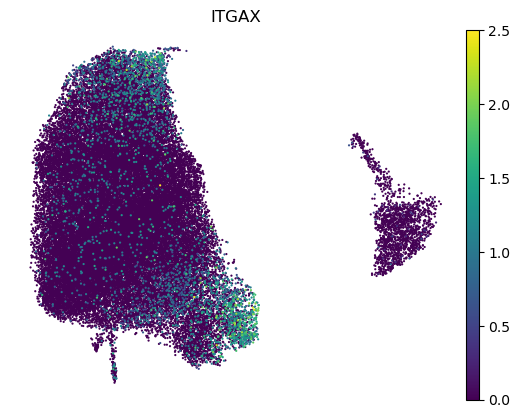

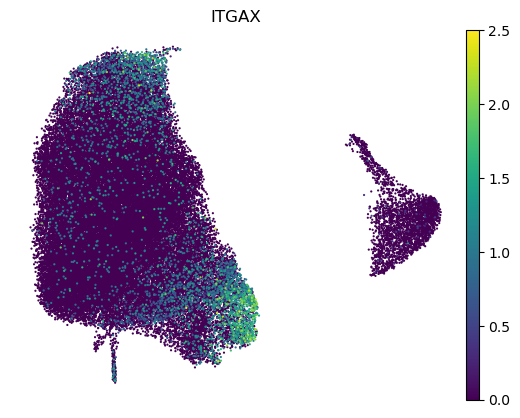

In [38]:
sc.pl.umap(sampled_adata_D0,color='ITGAX',size=10,show=False,frameon=False,use_raw=False,legend_loc=None, vmax=2.5)

sc.pl.umap(sampled_adata_D7,color='ITGAX',size=10,show=False,frameon=False,use_raw=False,legend_loc=None, vmax=2.5)


In [ ]:
sc.pl.umap(sampled_adata_D0,color='CD38',size=5,show=False,use_raw=False,frameon=False,legend_loc=None)

sc.pl.umap(sampled_adata_D7,color='CD38',size=5,show=False,use_raw=False,frameon=False,legend_loc=None)


<Axes: title={'center': 'AIFI_L3'}, xlabel='UMAP1', ylabel='UMAP2'>

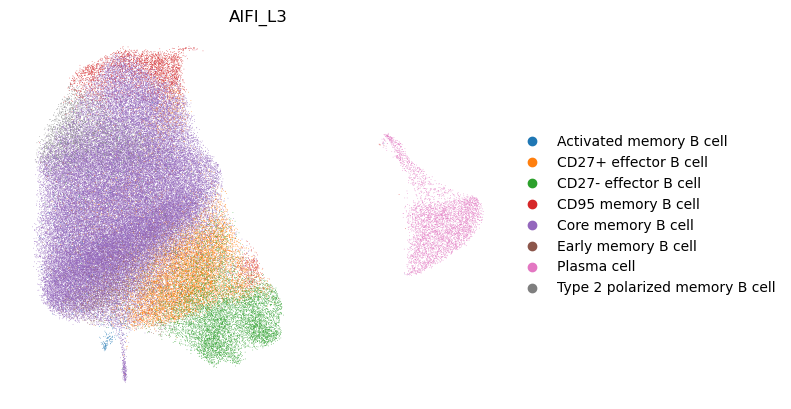

In [13]:
sc.pl.umap(
    sampled_adata,
        color='AIFI_L3',
        size=1,
        show=False,
        frameon=False)